In [1]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 27.8 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [2]:
import os, cv2, torch, random
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from glob import glob
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [18]:
# 📦 IMPORTS
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, cv2, torch, glob
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ SENTINEL2 DATASET
class Sentinel2Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, patch_size=512, stride=512):
        self.transform = transform
        self.patch_size = patch_size
        self.stride = stride
        self.image_dir = os.path.join(root_dir, split, "images")
        self.mask_dir = os.path.join(root_dir, split, "masks")
        self.image_files = sorted(glob.glob(os.path.join(self.image_dir, "*")))
        self.mask_files = sorted(glob.glob(os.path.join(self.mask_dir, "*")))
        assert len(self.image_files) == len(self.mask_files)
        self.patches = []
        for img_path, mask_path in zip(self.image_files, self.mask_files):
            img = cv2.imread(img_path)
            if img is None: continue
            h, w, _ = img.shape
            for y in range(0, h, self.stride):
                for x in range(0, w, self.stride):
                    if y + self.patch_size <= h and x + self.patch_size <= w:
                        self.patches.append((img_path, mask_path, x, y))
    def __len__(self):
        return len(self.patches)
    def __getitem__(self, idx):
      img_path, mask_path, x, y = self.patches[idx]

      image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      image_patch = image[y:y+self.patch_size, x:x+self.patch_size]
      mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]

      # Normalisation
      mask_patch = (mask_patch > 127).astype(np.float32)

      if self.transform:
        augmented = self.transform(image=image_patch, mask=mask_patch)
        image_patch = augmented['image']            # tensor (3, H, W)
        mask_patch = augmented['mask'].unsqueeze(0) # tensor (1, H, W)

      # ✅ Return obligatoires — ne JAMAIS transformer encore avec torch.tensor(...)
      return image_patch.float(), mask_patch.float()


# ✅ AUGMENTATIONS
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(), A.VerticalFlip(), A.RandomRotate90(),
            A.ShiftScaleRotate(0.05, 0.05, 15, p=0.5),
            A.Normalize(), ToTensorV2()
        ])
    else:
        return A.Compose([A.Normalize(), ToTensorV2()])

# ✅ LOSS
class BCEDiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        assert target is not None, "target est None dans BCEDiceLoss"
        bce = self.bce(pred, target)
        pred = torch.sigmoid(pred)
        smooth = 1.
        inter = (pred * target).sum()
        dice = (2. * inter + smooth) / (pred.sum() + target.sum() + smooth)
        return bce + (1 - dice)

# ✅ METRICS
def compute_metrics(y_true, y_pred):
    y_true, y_pred = y_true.flatten(), y_pred.flatten()
    return {
        'IoU': jaccard_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred)
    }

class StripAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        reduced = in_channels // reduction
        self.conv1 = nn.Conv1d(in_channels, reduced, 1)
        self.conv_h = nn.Conv1d(reduced, in_channels, 1)
        self.conv_w = nn.Conv1d(reduced, in_channels, 1)

    def forward(self, x):
        B, C, H, W = x.size()
        pool_h = F.adaptive_avg_pool2d(x, (H, 1)).view(B, C, H)
        pool_w = F.adaptive_avg_pool2d(x, (1, W)).view(B, C, W)
        pool_h = self.conv1(pool_h)
        pool_w = self.conv1(pool_w)
        attn_h = torch.sigmoid(self.conv_h(pool_h)).view(B, C, H, 1)
        attn_w = torch.sigmoid(self.conv_w(pool_w)).view(B, C, 1, W)
        return x * attn_h * attn_w

class DCSA(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.dilated = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 3, padding=r, dilation=r),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(),
                StripAttention(in_channels)
            ) for r in [1, 2, 4, 8]
        ])
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels, 1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            StripAttention(in_channels)
        )
        self.output = nn.Conv2d(in_channels * 5, in_channels, 1)

    def forward(self, x):
        out = [layer(x) for layer in self.dilated]
        gp = F.interpolate(self.global_pool(x), size=x.shape[2:], mode='bilinear', align_corners=False)
        out.append(gp)
        out = torch.cat(out, dim=1)
        return self.output(out)

class MSCM(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, (1, 5), padding=(0, 2)),
            nn.Conv2d(in_channels, in_channels, (5, 1), padding=(2, 0))
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, (1, 7), padding=(0, 3)),
            nn.Conv2d(in_channels, in_channels, (7, 1), padding=(3, 0)),
            nn.Conv2d(in_channels, in_channels, (1, 7), padding=(0, 3)),
            nn.Conv2d(in_channels, in_channels, (7, 1), padding=(3, 0))
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, (1, 11), padding=(0, 5)),
            nn.Conv2d(in_channels, in_channels, (11, 1), padding=(5, 0)),
            nn.Conv2d(in_channels, in_channels, (1, 11), padding=(0, 5)),
            nn.Conv2d(in_channels, in_channels, (11, 1), padding=(5, 0))
        )
        self.output = nn.Conv2d(in_channels * 3, in_channels, 1)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        return self.output(torch.cat([b1, b2, b3], dim=1))

class GFFM(nn.Module):
    def __init__(self, in_c_e2, in_c_e3, in_c_e4, out_c):
        super().__init__()
        self.conv_e2 = nn.Conv2d(in_c_e2, out_c, 1)
        self.conv_e3 = nn.Conv2d(in_c_e3, out_c, 1)
        self.conv_e4 = nn.Conv2d(in_c_e4, out_c, 1)
        self.mscm = MSCM(out_c * 3)


    def forward(self, e2, e3, e4):
       e2 = F.interpolate(self.conv_e2(e2), size=e3.shape[2:], mode='bilinear', align_corners=False)
       e3 = self.conv_e3(e3)
       e4 = F.interpolate(self.conv_e4(e4), size=e3.shape[2:], mode='bilinear', align_corners=False)
       x = torch.cat([e2, e3, e4], dim=1)
       return self.mscm(x)


class AGFNet(nn.Module):
    def __init__(self):
        super().__init__()
        from torchvision.models import resnet34
        base = resnet34(pretrained=True)
        self.encoder0 = nn.Sequential(base.conv1, base.bn1, base.relu)
        self.encoder1 = base.layer1  # 64
        self.encoder2 = base.layer2  # 128
        self.encoder3 = base.layer3  # 256
        self.encoder4 = base.layer4  # 512

        self.dcsa = DCSA(512)

        self.gffm1 = GFFM(128, 256, 512, 128)
        self.gffm2 = GFFM(64, 128, 256, 64)
        self.gffm3 = GFFM(64, 64, 128, 64)

        self.up4 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up1 = nn.ConvTranspose2d(64, 64, 2, 2)

        self.dec4 = nn.Conv2d(256 + 384, 256, 3, padding=1)  # 256 + GFFM(128×3)
        self.dec3 = nn.Conv2d(128 + 192, 128, 3, padding=1)  # 128 + GFFM(64×3)
        self.dec2 = nn.Conv2d(64 + 192, 64, 3, padding=1)    # 64 + GFFM(64×3)

        self.dec1 = nn.Conv2d(64 + 64, 64, 3, padding=1)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e0 = self.encoder0(x)
        e1 = self.encoder1(e0)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        x = self.dcsa(e4)

        d4 = self.up4(x)
        d4 = torch.cat([d4, self.gffm1(e2, e3, e4)], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, self.gffm2(e1, e2, e3)], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, self.gffm3(e0, e1, e2)], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        e0_resized = F.interpolate(e0, size=d1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([d1, e0_resized], dim=1))

        out = self.final(d1)
        return out  # ✅ C'EST ÇA QUI MANQUAIT 🎯
model = AGFNet().to(device)


# ✅ TRAIN & EVAL
from tqdm import tqdm

def train_one_epoch(model, loader, opt, loss_fn):
    model.train(); total = 0
    for x, y in tqdm(loader, desc="Training"):
        
        

        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        opt.step()
        total += loss.item()
    return total / len(loader)

def evaluate(model, loader, loss_fn):
    model.eval(); total = 0; yp, yt = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y); total += loss.item()
            p = (torch.sigmoid(out) > 0.5).cpu().numpy()
            yp.append(p); yt.append(y.cpu().numpy())
    return total / len(loader), compute_metrics(np.concatenate(yt), np.concatenate(yp))

# ✅ CHARGEMENT DES DONNÉES
train_ds = Sentinel2Dataset("/kaggle/input/dpglobe/deepglobe", split='train', transform=get_transforms(True))
val_ds   = Sentinel2Dataset("/kaggle/input/dpglobe/deepglobe", split='valid', transform=get_transforms(False))
train_ds = torch.utils.data.Subset(train_ds, list(range(0, 500)))  # ← 500 patchs max
val_ds = torch.utils.data.Subset(val_ds, list(range(0, 100)))

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4)

# ✅ INITIALISATION
model = AGFNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = BCEDiceLoss()
print(f"✅ Démarrage de l'entraînement...")
# ✅ ENTRAÎNEMENT
for epoch in range(1, 6):
    tl = train_one_epoch(model, train_loader, opt, loss_fn)
    vl, metrics = evaluate(model, val_loader, loss_fn)
    print(f"[{epoch}] TL: {tl:.4f} | VL: {vl:.4f} | IoU: {metrics['IoU']:.4f}, F1: {metrics['F1']:.4f}")


✅ Démarrage de l'entraînement...


Training: 100%|██████████| 125/125 [03:37<00:00,  1.74s/it]


[1] TL: 1.6652 | VL: 2.5766 | IoU: 0.0494, F1: 0.0941


Training: 100%|██████████| 125/125 [03:36<00:00,  1.73s/it]


[2] TL: 1.0008 | VL: 1.0209 | IoU: 0.1429, F1: 0.2500


Training: 100%|██████████| 125/125 [03:36<00:00,  1.73s/it]


[3] TL: 0.8884 | VL: 0.8569 | IoU: 0.2487, F1: 0.3984


Training: 100%|██████████| 125/125 [03:36<00:00,  1.73s/it]


[4] TL: 0.7711 | VL: 0.8335 | IoU: 0.2247, F1: 0.3669


Training: 100%|██████████| 125/125 [03:36<00:00,  1.73s/it]


[5] TL: 0.7300 | VL: 0.7039 | IoU: 0.2986, F1: 0.4599


In [23]:
def unnormalize(img):
    # Valeurs par défaut de A.Normalize()
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)
    img = (img * std + mean)
    img = np.clip(img, 0, 1)
    return img


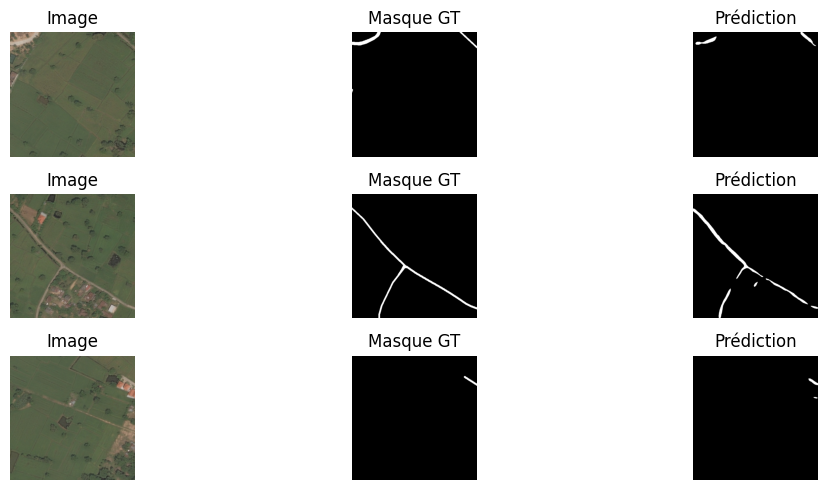

In [25]:
model.eval()
x, y = next(iter(val_loader))
x, y = x.to(device), y.to(device)

with torch.no_grad():
    preds = torch.sigmoid(model(x)) > 0.5

plt.figure(figsize=(12, 5))
for i in range(3):
    # ✅ Image originale dénormalisée
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(unnormalize(x[i]))
    plt.title("Image")
    plt.axis("off")

    # Masque GT
    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(y[i][0].cpu(), cmap='gray')
    plt.title("Masque GT")
    plt.axis("off")

    # Prédiction
    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(preds[i][0].cpu(), cmap='gray')
    plt.title("Prédiction")
    plt.axis("off")

plt.tight_layout()
plt.show()


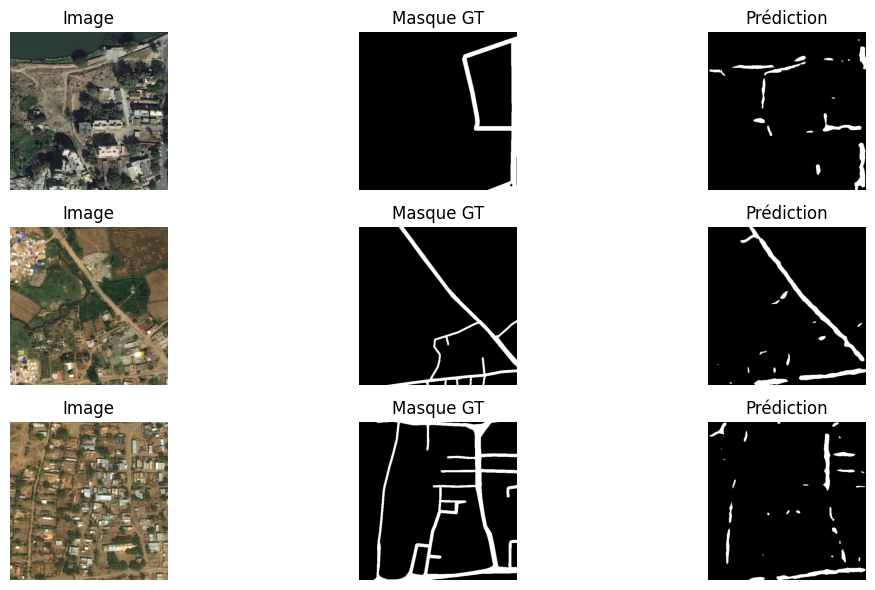

In [57]:
import random
import matplotlib.pyplot as plt

def unnormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img * std + mean)
    return np.clip(img, 0, 1)

# ✅ Prédictions sur images aléatoires du val_loader
model.eval()
indices = random.sample(range(len(val_ds)), 3)  # Choisir 3 indices au hasard

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    img, mask = val_ds[idx]
    img_tensor = img.unsqueeze(0).to(device)  # (1, 3, H, W)

    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor)) > 0.5

    # 📷 Image originale
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(unnormalize(img))
    plt.title("Image")
    plt.axis("off")

    # 🎯 Masque GT
    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(mask[0], cmap="gray")
    plt.title("Masque GT")
    plt.axis("off")

    # 🤖 Prédiction
    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(pred[0][0].cpu(), cmap="gray")
    plt.title("Prédiction")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [42]:
def unnormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img * std + mean)
    return np.clip(img, 0, 1)

def predict_from_path(image_path, mask_path=None):
    # Lire image + masque si fourni
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    if mask_path:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        mask = (mask > 127).astype(np.float32)
    else:
        mask = None

    # Redimensionner si nécessaire (AGFNet exige que les dimensions soient divisibles par 32)
    h, w, _ = image.shape
    new_h, new_w = (h // 32) * 32, (w // 32) * 32
    image = cv2.resize(image, (new_w, new_h))
    if mask is not None:
        mask = cv2.resize(mask, (new_w, new_h))

    # Normaliser + tensor
    transform = get_transforms(train=False)
    augmented = transform(image=image, mask=mask if mask is not None else np.zeros((new_h, new_w)))
    img_tensor = augmented['image'].unsqueeze(0).to(device)
    mask_tensor = augmented['mask'] if mask is not None else None

    # Prédiction
    model.eval()
    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor)) > 0.5

    # Affichage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(unnormalize(img_tensor[0]))
    plt.title("Image")
    plt.axis("off")

    if mask_tensor is not None:
        plt.subplot(1, 3, 2)
        plt.imshow(mask_tensor.cpu(), cmap='gray')
        plt.title("Masque GT")
        plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred[0][0].cpu(), cmap='gray')
    plt.title("Prédiction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


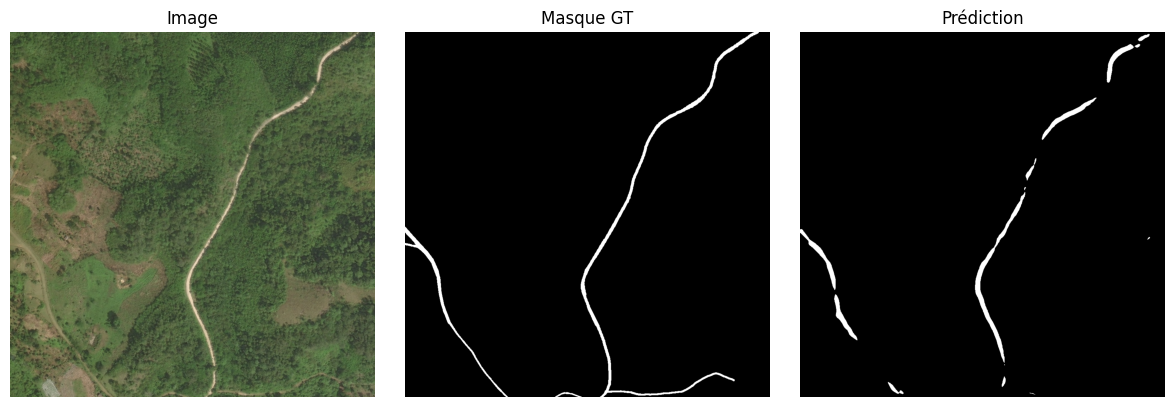

In [52]:
# Exemple avec image et masque
predict_from_path("/kaggle/input/dpglobe/deepglobe/train/images/100034_sat.jpg",
                  "/kaggle/input/dpglobe/deepglobe/train/masks/100034_mask.png")


